* Cluster -vs- single-cell coverages 
* ATAC dynamics at metaells

* Contour plots for metacell illustration


# Imports

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
import scanpy as sc
import pyranges as pr
import warnings

In [3]:
import palantir 
import phenograph
import harmony

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [4]:
pd.__version__


'1.1.5'

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
matplotlib.rcParams["font.family"] = "Helvetica"

In [7]:
%env R_HOME=/usr/lib64/R

env: R_HOME=/usr/lib64/R


In [8]:
plot_prefix = 'plots/Fig2_'

# Utility functions

In [9]:
def log_transform(ad, ps=0.1):
    ad.X.data = np.log2(ad.X.data + ps) - np.log2(ps)

In [10]:
from joblib import Parallel, delayed
from scipy.sparse import hstack, csr_matrix, issparse
import gc


def _dot_func(x, y):
    return x.dot(y)


def impute_data(dm_res, ad, n_steps=3):
    T_steps = dm_res['T'] ** n_steps
    T_steps = T_steps.astype(np.float32)

    # RUn in parallel
    seq = np.append(np.arange(0, ad.X.shape[1], 100), [ad.X.shape[1]])
    res = Parallel(n_jobs=-1)(delayed(_dot_func)(T_steps, ad.X[:, seq[i - 1]:seq[i]]) for i in range(1, len(seq)))
    imputed_data = hstack(res)
    imputed_data = imputed_data.todense()
    imputed_data[imputed_data < 1e-2] = 0
    gc.collect()

    return imputed_data

In [11]:
def pyranges_from_strings(pos_list):
    # Chromosome and positions
    chr = pos_list.str.split(':').str.get(0)
    start = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(0)
    end = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(1)
    
    # Create ranges
    gr = pr.PyRanges(chromosomes=chr, starts=start, ends=end)
    
    return gr


def pyranges_to_strings(peaks):
    # Chromosome and positions
    chr = peaks.Chromosome.astype(str).values
    start = peaks.Start.astype(str).values
    end = peaks.End.astype(str).values
    
    # Create ranges
    gr = chr + ':' + start + '-' + end
    
    return gr

In [12]:
def plot_gene_expression(
    data,
    tsne,
    genes,
    plot_scale=False,
    n_cols=5,
    percentile=0,
    s=3,
    cmap=matplotlib.cm.Spectral_r,
):
    """ Plot gene expression on tSNE maps
    :param genes: Iterable of strings to plot on tSNE
    """

    not_in_dataframe = set(genes).difference(data.columns)
    if not_in_dataframe:
        if len(not_in_dataframe) < len(genes):
            print(
                "The following genes were either not observed in the experiment, "
                "or the wrong gene symbol was used: {!r}".format(not_in_dataframe)
            )
        else:
            print(
                "None of the listed genes were observed in the experiment, or the "
                "wrong symbols were used."
            )
            return

    # remove genes missing from experiment
    genes = pd.Series(genes)[pd.Series(genes).isin(data.columns)]

    # Plot
    cells = data.index.intersection(tsne.index)
    fig = palantir.plot.FigureGrid(len(genes), n_cols)

    for g, ax in zip(genes, fig):
        # Data
        c = data.loc[cells, g]
        vmin = np.percentile(c[~np.isnan(c)], percentile)
        vmax = np.percentile(c[~np.isnan(c)], 100 - percentile)

        ax.scatter(
            tsne.loc[cells, "x"],
            tsne.loc[cells, "y"],
            s=s,
            c=c,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
        )
        ax.set_axis_off()
        ax.set_title(g)

        if plot_scale:
            normalize = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
            cax, _ = matplotlib.colorbar.make_axes(ax)
            matplotlib.colorbar.ColorbarBase(cax, norm=normalize, cmap=cmap)



In [13]:

def plot_gene_trends(gene_trends, genes=None, colors=None, plot_std=True):
    """ Plot the gene trends: each gene is plotted in a different panel
    :param: gene_trends: Results of the compute_marker_trends function
    """

    # Branches and genes
    branches = list(gene_trends.keys())
    if colors is None:
        colors = pd.Series(
            sns.color_palette("Set2", len(branches)).as_hex(), index=branches
        )
    if genes is None:
        genes = gene_trends[branches[0]]["trends"].index

    # Set up figure
    fig = plt.figure(figsize=[7, 3 * len(genes)])
    for i, gene in enumerate(genes):
        ax = fig.add_subplot(len(genes), 1, i + 1)
        for branch in branches:
            trends = gene_trends[branch]["trends"]
            stds = gene_trends[branch]["std"]
            ax.plot(
                trends.columns, trends.loc[gene, :], color=colors[branch], label=branch
            )
            ax.set_xticks([0, 1])
            if plot_std:
                ax.fill_between(
                    trends.columns,
                    trends.loc[gene, :] - stds.loc[gene, :],
                    trends.loc[gene, :] + stds.loc[gene, :],
                    alpha=0.1,
                    color=colors[branch],
                )
            ax.set_title(gene)
        # Add legend
        if i == 0:
            ax.legend()

    sns.despine()


# Load data

In [14]:
data_dir = os.path.expanduser('/home/ec2-user/scratch/')

In [15]:
rna_ad = sc.read(data_dir + 'cd34_multiome_rna_no_bcells.h5ad')
atac_ad = sc.read(data_dir + 'cd34_multiome_atac_no_bcells.h5ad')

In [16]:
celltypes = rna_ad.obs['celltype'].astype(str)
celltypes[rna_ad.obs['phenograph'] == '4'] = 'DCPre'
cats = rna_ad.obs['celltype'].values.categories.append(pd.Index(['DCPre']))
rna_ad.obs['celltype'] = pd.Categorical(celltypes, cats)

In [17]:
rna_ad.uns['celltype_colors'] = np.append(rna_ad.uns['celltype_colors'], ['#a6bddb'])

In [59]:
atac_ad

AnnData object with n_obs × n_vars = 6881 × 246113
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP', 'leiden', 'phenograph', 'celltype', 'rnaPhenograph', 'rnaLeiden', 'Metacell', 'palantir_pseudotime', 'palantir_diff_potential', 'Metacell_Entropy', 'FragSample'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx'
    uns: 'DM_EigenValues', 'GeneScoresColums', 'celltype_colors', 'leiden', 'leiden_colors', 'neighbors', 'palantir_branch_probs_columns', 'phenograph_colors', 'rnaLeiden_colors', 'rnaPhenograph_colors', 'umap'
    obsm: 'DM_EigenVectors', 'GeneScores', 'X_FDL', 'X_svd', 'X_umap', 'palantir_branch_probs'
    lay

In [60]:
atac_ad.var['GC']

chr1:816070-816570          0.2894
chr1:817092-817592          0.4790
chr1:827266-827766          0.6926
chr1:838271-838771          0.4611
chr1:842638-843138          0.5689
                             ...  
chrX:155966799-155967299    0.4032
chrX:155968119-155968619    0.4930
chrX:155968739-155969239    0.4731
chrX:155971635-155972135    0.4531
chrX:155975882-155976382    0.5090
Name: GC, Length: 246113, dtype: float64

In [18]:
rna_ad

AnnData object with n_obs × n_vars = 6881 × 12464
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'Metacell', 'palantir_pseudotime', 'palantir_diff_potential'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'DMEigenValues', 'celltype_colors', 'ct_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'palantir_branch_probs_columns', 'pca', 'phenograph_colors', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'X_FDL', 'X_pca', 'X_umap', 'palantir_branch_probs'
    varm: 'PCs'
    layers: 'MAGIC_imputed_data'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

In [19]:
atac_ad

AnnData object with n_obs × n_vars = 6881 × 246113
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP', 'leiden', 'phenograph', 'celltype', 'rnaPhenograph', 'rnaLeiden', 'Metacell', 'palantir_pseudotime', 'palantir_diff_potential', 'Metacell_Entropy'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx'
    uns: 'DM_EigenValues', 'GeneScoresColums', 'celltype_colors', 'leiden', 'leiden_colors', 'neighbors', 'palantir_branch_probs_columns', 'phenograph_colors', 'rnaLeiden_colors', 'rnaPhenograph_colors', 'umap'
    obsm: 'DM_EigenVectors', 'GeneScores', 'X_FDL', 'X_svd', 'X_umap', 'palantir_branch_probs'
    layers: 'TFIDF'
 

In [20]:
# Diffusion maps object
dm_res = dict()
dm_res['EigenVectors'] = pd.DataFrame(rna_ad.obsm['DM_EigenVectors'], 
                                     index=rna_ad.obs_names)
dm_res['EigenValues'] = rna_ad.uns['DMEigenValues']
dm_res['kernel'] = rna_ad.obsp['DM_Kernel']

In [21]:
# Diffusion maps object
atac_dm_res = dict()
atac_dm_res['EigenVectors'] = pd.DataFrame(atac_ad.obsm['DM_EigenVectors'], 
                                     index=atac_ad.obs_names)
atac_dm_res['EigenValues'] = atac_ad.uns['DM_EigenValues']
atac_dm_res['kernel'] = atac_ad.obsp['DM_kernel']

# Metacell -vs- cluster examples

## Coverage plot functions

In [22]:
import tabix
import subprocess

import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

In [23]:
def compute_coverage(fragments_files, region, barcodes, out_prefix, 
                     smooth=None, normalize=False, frag_type='All'):

    # Bed file
    bed_file = open(out_prefix + '.bed', 'w')

    for sample in fragments_files.keys():
        tb = tabix.open(fragments_files[sample])
        records = tb.querys(region)
    
        # Iterate and write bed file
        for record in records:
            if record[3] in barcodes[sample]:
                # Write to bed file if the read is NFR
                if frag_type == 'NFR' and int(record[2]) - int(record[1]) > 145:
                    continue 
                if frag_type == 'NUC' and int(record[2]) - int(record[1]) <= 145:
                    continue 

                # Write to bed file
                line = record[0] + '\t' + record[1] + '\t' + record[2] + '\n'
                bed_file.writelines(line)

    # Close bed file
    bed_file.close()

    # Region to bed
    line = region.replace(':', '\t').replace('-', '\t') + '\n'
    bed_file = open(out_prefix + '.region.bed', 'w')
    bed_file.writelines(line)
    bed_file.close()

    # Coverage
    out_file = open(out_prefix + '.coverage.bed', 'w')
    args = ['bedtools', 'coverage', '-a', out_prefix + '.region.bed', '-b',
            out_prefix + '.bed', '-d']
    subprocess.call(args, stdout=out_file)
    out_file.close()

    # Read coverage
    df = pd.read_csv(out_prefix + '.coverage.bed', sep='\t', header=None)
    coverage = pd.Series(df[4].values, index=df[1] + df[3] - 1)
    coverage.attrs['chr'] = df[0][0]

    # Smooth if specified
    if smooth:
        coverage = coverage.rolling(smooth).mean()
        coverage[coverage.isnull()] = coverage.iloc[smooth]

    if normalize:
        nFrags = 0
        for sample in barcodes.index:
            sample_bc = (rna_ad.obs_names.str.contains(sample)) & (rna_ad.obs['FragSample'].isin(barcodes[sample]))
            nFrags += rna_ad.obs['nFrags'][sample_bc].sum()
        norm = 1e6 / nFrags
        coverage = coverage * norm

    # Clean up
    os.unlink(out_prefix + '.bed')
    os.unlink(out_prefix + '.coverage.bed')
    os.unlink(out_prefix + '.region.bed')

    return coverage

In [24]:
# Plot coverage
def _plot_coverage(coverage, track_name='Coverage', ax=None, color='#ff7f00',
                   min_coverage=0, ylim=None, fill=True, linestyle='-', y_font=None):
    if ax is None:
        plt.figure()
        ax = plt.gca()

    if y_font is not None:
        ax.tick_params(axis='y', labelsize=y_font)

    # Plot and fill
    values = coverage
    values[values <= min_coverage] = 0
    if fill:
        ax.plot(coverage.index, values, color='black', linewidth=0.5)
        ax.fill_between(coverage.index, 0, values, color=color)
#         ax.set_ylabel(track_name)
    else:
        ax.plot(coverage.index, values, color=color, 
                linestyle=linestyle, linewidth=0.75)

        
    # Scale
    if ylim is not None:
        ax.set_ylim(ylim)
    sns.despine(ax=ax)

    
# BED plot
def _plot_bed(plot_peaks, track_name="Bed", ax=None, facecolor='#ff7f00'):

    if ax is None:
        plt.figure()
        ax = plt.gca()
    
    rects = []
    if len(plot_peaks) > 0:
        for s, e in zip(plot_peaks.Start, plot_peaks.End):
            rects.append(Rectangle((s, -0.35), e - s, 0.7))

    # Add rectangles
    # Dummy scatter
    pc = PatchCollection(rects, facecolor=facecolor, edgecolor='black')
    ax.add_collection(pc)

    # Axis annotation
    ax.set_ylim([-1, 1])
    sns.despine(ax=ax, bottom=True)
    ax.set_yticks([])
#     ax.set_ylabel(track_name, rotation=0)
    ax.axes.get_xaxis().set_visible(False)


# Gene plot
def _plot_gene(genes, ax=None, track_name='Genes', facecolor='#377eb8',
               exon_height=0.9, utr_height=0.4):
    # Setup plot
    if ax is None:
        plt.figure()
        ax = plt.gca()

    for gene in np.unique(genes.gene_name):
        gene_pr = genes[genes.gene_name == gene]

        # Plot lines
        gs, ge = gene_pr[gene_pr.Feature == 'gene'].Start.values[0], gene_pr[gene_pr.Feature == 'gene'].End.values[0]
        ax.plot([gs, ge], [0, 0], color='black')
        ax.set_ylim([-1, 1])
#         ax.text((gs + ge) / 2,
#                 -(exon_height + utr_height), gene, horizontalalignment='center')

        # UTRs
        utrs = gene_pr[gene_pr.Feature.astype(str).str.contains('utr')]
        if len(utrs) > 0:
            rects = []
            for s, e in zip(utrs.Start, utrs.End):
                rects.append(Rectangle((s, -utr_height / 2), e - s, utr_height))
            ax.add_collection(PatchCollection(rects, facecolor=facecolor, edgecolor='black'))

        # CDS
        cds = gene_pr[gene_pr.Feature.astype(str).str.contains('CDS')]
        if len(cds) == 0:
            cds = gene_pr[gene_pr.Feature.astype(str).str.contains('exon')]
        rects = []
        for s, e in zip(cds.Start, cds.End):
            rects.append(Rectangle((s, -exon_height / 2), e - s, exon_height))
        ax.add_collection(PatchCollection(rects, facecolor=facecolor, edgecolor='black'))

        # Arrow indicating direction
#         rs, re = ax.get_xlim()
#         if gene_pr.stranded:
#             s, e = cds.Start.values[0], cds.End.values[0]
#             if gene_pr.Strand.values[0] == '+':
#                 ax.plot([s, e], np.repeat(-0.65, 2), color='red', linewidth=1, alpha=1)
#                 ax.plot([e - (re - rs) / 100, e], [-0.95, -0.65], color='red', linewidth=1, alpha=1)
#                 ax.plot([e - (re - rs) / 100, e], [-0.35, -0.65], color='red', linewidth=1, alpha=1)
#             else:
#                 ax.plot([s, e], np.repeat(-0.65, 2), color='red', linewidth=1, alpha=1)
#                 ax.plot([s + (re - rs) / 100, s], [-0.95, -0.65], color='red', linewidth=1, alpha=1)
#                 ax.plot([s + (re - rs) / 100, s], [-0.35, -0.65], color='red', linewidth=1, alpha=1)

    # Axis clean up
#     ax.set_ylabel(track_name)
    sns.despine(ax=ax)
    ax.set_yticks([])

In [25]:
def plot_coverage(barcode_groups, region, fragments_files,
                  peak_groups=None, genes=None, highlight_peaks=None,
                  min_coverage=0, smooth=None, common_scale=False,
                  plot_cov_size=2, plot_bed_size=0.75, collapsed=False,
                  coverage_colors=None, fig_width=15, frag_type='All', 
                  normalize=True, y_font=None):

    # Determine coverages
    coverages = dict()
    for k in barcode_groups.index:
        iter_norm = normalize
        if k == 'Single-cell':
            iter_norm = False
        coverages[k] = compute_coverage(fragments_files, region, barcode_groups[k],
                                        '/tmp/test', smooth, iter_norm, frag_type)
    # Plot
    n_rows = len(coverages)
    size = plot_cov_size * n_rows
    ratios = np.repeat(1, n_rows)
    if collapsed:
        n_rows = 1
        size = plot_cov_size * 4
        ratios = np.repeat(4, 1)
    if peak_groups is not None:
        size += plot_bed_size * len(peak_groups)
        n_rows += len(peak_groups)
        ratios = np.append(ratios, np.repeat(plot_bed_size / plot_cov_size, len(peak_groups)))
    if genes is not None:
        size += plot_bed_size
        n_rows += 1
        ratios = np.append(ratios, plot_bed_size / plot_cov_size)

    # Colors
    if coverage_colors is None:
        coverage_colors = pd.Series(sns.color_palette('Set2', len(coverages)).as_hex(),
                                    index=barcode_groups.index)

    # Y min and max
    ylim = None
    if common_scale:
        ymin = np.inf
        ymax = -np.inf
        for row in barcode_groups.index:
            if row == 'Single-cell':
                continue
            ymin = np.min([ymin, np.min(coverages[row])])
            ymax = np.max([ymax, np.max(coverages[row])])
        ylim = [ymin, ymax]


    # Region pyranges
    pr_region = pr.from_dict({'Chromosome': [region.split(':')[0]],
                              'Start': [int(region.split(':')[1].split('-')[0])],
                              'End': [int(region.split('-')[1])]})
    if highlight_peaks is not None:
        highlight_peaks = highlight_peaks.overlap(pr_region)
        
    # Plot
    fig = plt.figure(figsize=[fig_width, size])
    gs = gridspec.GridSpec(n_rows, 1, height_ratios=ratios, figure=fig)

    # Coverages
    plot_index = 0
    if collapsed:
        ax = fig.add_subplot(gs[plot_index, 0])
        ax.set_xlim([pr_region.Start[0], pr_region.End[0]])
        plot_index += 1

    for row in barcode_groups.index:
        # Create subplot
        if not collapsed:
            ax = fig.add_subplot(gs[plot_index, 0])
            ax.set_xlim([pr_region.Start[0], pr_region.End[0]])
            plot_index += 1

        iter_ylim = ylim
        if row == 'Single-cell':
            iter_ylim = [0, 2]
        _plot_coverage(coverages[row], row, ax, coverage_colors[row],
                       min_coverage, iter_ylim, not collapsed, y_font=y_font)

        # Highlight peaks
        if highlight_peaks is not None:
            for s, e in zip(highlight_peaks.Start, highlight_peaks.End):
                rect = Rectangle((s, 0), e - s, ax.get_ylim()[1],
                                 color='black', alpha=0.07, zorder=1000)
                ax.add_patch(rect)

        # Reset axis
        if plot_index != n_rows:
            ax.set_xticks([])


    # Region pyranges
    pr_region = pr.from_dict({'Chromosome': [region.split(':')[0]],
                              'Start': [int(region.split(':')[1].split('-')[0])],
                              'End': [int(region.split('-')[1])]})

    # Peaks
    if peak_groups is not None:
        for row in peak_groups.index:
            plot_peaks = peak_groups[row].overlap(pr_region)

            ax = fig.add_subplot(gs[plot_index, 0])
            ax.set_xlim([pr_region.Start[0], pr_region.End[0]])
            plot_index += 1

            _plot_bed(plot_peaks, row, ax)

    # Genes
    if genes is not None:
        genes = genes.overlap(pr_region)
        genes.End[genes.End > pr_region.End[0]] = pr_region.End[0]
        genes.Start[genes.Start < pr_region.Start[0]] = pr_region.Start[0]


        # Setup plot
        ax = fig.add_subplot(gs[plot_index, 0])
        ax.set_xlim([pr_region.Start[0], pr_region.End[0]])
        plot_index += 1

        _plot_gene(genes, ax, track_name='Genes')

        # Axis clean up
#         ax.set_ylabel('Genes', rotation=0)
        sns.despine(ax=ax)
        ax.set_yticks([])


    # Clean up axis annotation
    ax.axes.get_xaxis().set_visible(True)
    locs = ax.get_xticks()[[0, -1]]
#     locs[0] += 10000
#     locs[1] -= 10000
    ax.set_xticks(locs)
    ax.set_xticklabels([str(int(t)) for t in ax.get_xticks()])
    ax.set_xlabel(region.split(':')[0])



In [26]:
def plot_coverage_combined(coverages,region, sec_coverages=None, 
                  peak_groups=None, genes=None, highlight_peaks=None,
                  min_coverage=0, smooth=None, common_scale=False,
                  plot_cov_size=2, plot_bed_size=0.75, collapsed=False,
                  coverage_colors=None, fig_width=15, frag_type='All', normalize=True):

    # Plot
    n_rows = len(coverages)
    size = plot_cov_size * n_rows
    ratios = np.repeat(1, n_rows)
    if collapsed:
        n_rows = 1
        size = plot_cov_size * 4
        ratios = np.repeat(4, 1)
    if peak_groups is not None:
        size += plot_bed_size * len(peak_groups)
        n_rows += len(peak_groups)
        ratios = np.append(ratios, np.repeat(plot_bed_size / plot_cov_size, len(peak_groups)))
    if genes is not None:
        size += plot_bed_size
        n_rows += 1
        ratios = np.append(ratios, plot_bed_size / plot_cov_size)

    # Colors
    if coverage_colors is None:
        coverage_colors = pd.Series(sns.color_palette('Set2', len(coverages)).as_hex(),
                                    index=barcode_groups.index)

    # Y min and max
    ylim = None
    if common_scale:
        ymin = np.inf
        ymax = -np.inf
        for row in barcode_groups.index:
            if row == 'Single-cell':
                continue
            ymin = np.min([ymin, np.min(coverages[row])])
            ymax = np.max([ymax, np.max(coverages[row])])
        ylim = [ymin, ymax]


    # Region pyranges
    pr_region = pr.from_dict({'Chromosome': [region.split(':')[0]],
                              'Start': [int(region.split(':')[1].split('-')[0])],
                              'End': [int(region.split('-')[1])]})
    if highlight_peaks is not None:
        highlight_peaks = highlight_peaks.overlap(pr_region)
        
    # Plot
    fig = plt.figure(figsize=[fig_width, size])
    gs = gridspec.GridSpec(n_rows, 1, height_ratios=ratios, figure=fig)

    # Coverages
    plot_index = 0
    if collapsed:
        ax = fig.add_subplot(gs[plot_index, 0])
        ax.set_xlim([pr_region.Start[0], pr_region.End[0]])
        plot_index += 1

    for row in barcode_groups.index:
        # Create subplot
        if not collapsed:
            ax = fig.add_subplot(gs[plot_index, 0])
            ax.set_xlim([pr_region.Start[0], pr_region.End[0]])
            plot_index += 1

        iter_ylim = ylim
        if row == 'Single-cell':
            iter_ylim = [0, 2]
        _plot_coverage(coverages[row], row, ax, coverage_colors[row],
                       min_coverage, iter_ylim, not collapsed)
        if sec_coverages is not None:
            _plot_coverage(sec_coverages[row], row, ax, 'black',
                           min_coverage, iter_ylim, False, linestyle='--')

        # Highlight peaks
        if highlight_peaks is not None:
            for s, e in zip(highlight_peaks.Start, highlight_peaks.End):
                rect = Rectangle((s, 0), e - s, ax.get_ylim()[1],
                                 color='black', alpha=0.07, zorder=1000)
                ax.add_patch(rect)

        # Reset axis
        if plot_index != n_rows:
            ax.set_xticks([])


    # Region pyranges
    pr_region = pr.from_dict({'Chromosome': [region.split(':')[0]],
                              'Start': [int(region.split(':')[1].split('-')[0])],
                              'End': [int(region.split('-')[1])]})

    # Peaks
    if peak_groups is not None:
        for row in peak_groups.index:
            plot_peaks = peak_groups[row].overlap(pr_region)

            ax = fig.add_subplot(gs[plot_index, 0])
            ax.set_xlim([pr_region.Start[0], pr_region.End[0]])
            plot_index += 1

            _plot_bed(plot_peaks, row, ax)

    # Genes
    if genes is not None:
        genes = genes.overlap(pr_region)
        genes.End[genes.End > pr_region.End[0]] = pr_region.End[0]
        genes.Start[genes.Start < pr_region.Start[0]] = pr_region.Start[0]


        # Setup plot
        ax = fig.add_subplot(gs[plot_index, 0])
        ax.set_xlim([pr_region.Start[0], pr_region.End[0]])
        plot_index += 1

        _plot_gene(genes, ax, track_name='Genes')

        # Axis clean up
#         ax.set_ylabel('Genes', rotation=0)
        sns.despine(ax=ax)
        ax.set_yticks([])


    # Clean up axis annotation
    ax.axes.get_xaxis().set_visible(True)
    locs = ax.get_xticks()[[0, -1]]
#     locs[0] += 10000
#     locs[1] -= 10000
    ax.set_xticks(locs)
    ax.set_xticklabels([str(int(t)) for t in ax.get_xticks()])
    ax.set_xlabel(region.split(':')[0])



## GTF

In [27]:
gtf = pr.read_gtf(os.path.expanduser('~/data/genomes/hg38.gtf'))
gtf.Chromosome = 'chr' + gtf.Chromosome.astype(str)

## Fragment files

In [28]:
frag_dir = os.path.expanduser('~/projects/metacells/data/CD34/Multiome/')

fragment_files = dict()
fragment_files['cd34_multiome_rep2'] = frag_dir + 'rep2/atac_fragments.tsv.gz'
fragment_files['cd34_multiome_rep1'] = frag_dir + 'rep1/atac_fragments.tsv.gz'

## Chromsizes

In [29]:
chromsizes = os.path.expanduser('~/projects/metacells/data/CD34/ATAC/chromsizes')

## Peaks

In [30]:
peak_groups = pd.Series()
peak_groups['Peaks'] = pyranges_from_strings(atac_ad.var_names)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


# Plots - GATA2

In [31]:
# Pax5 locus 
region = 'chr3:128,446,488-128,504,927'.replace(',', '')
pr_region = pr.from_dict({'Chromosome': [region.split(':')[0]],
                              'Start': [int(region.split(':')[1].split('-')[0])],
                              'End': [int(region.split('-')[1])]})

genes = gtf.intersect(pr_region)
genes = genes[genes.gene_name == 'GATA2']

region = 'chr3:128,446,488-128,499,744'.replace(',', '')

In [32]:
highlight_peaks = pyranges_from_strings(pd.Series(pyranges_to_strings(peak_groups['Peaks'].intersect(
    pr_region))[[3, 6,
                 11,  24]]))

In [33]:
atac_ad.obs['FragSample'] = atac_ad.obs_names.str.split('#').str.get(1).astype(str)
rna_ad.obs['FragSample'] = rna_ad.obs_names.str.split('#').str.get(1).astype(str)
rna_ad.obs['nFrags'] = atac_ad.obs['nFrags']

In [34]:
test_clusters = ['4']
cluster_colors = pd.Series(['#e41a1c',], 
                           index=['MEP'])

In [35]:
ct_colors = pd.Series(rna_ad.uns['celltype_colors'], 
                     index=rna_ad.obs['celltype'].values.categories)

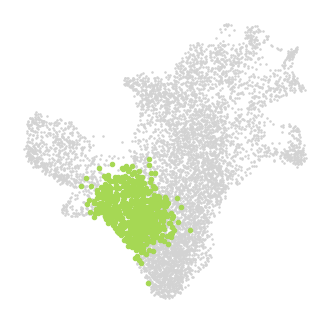

In [36]:
plt.figure()
basis = 'X_umap'
plt.scatter(rna_ad.obsm[basis][:, 0], 
            rna_ad.obsm[basis][:, 1], s=1, color='lightgrey')
for c in test_clusters:
    cells = rna_ad.obs_names[rna_ad.obs['leiden'] == c]
    plt.scatter(rna_ad[cells].obsm[basis][:, 0], 
            rna_ad[cells].obsm[basis][:, 1], s=10, 
                color=ct_colors['MEP'])
ax = plt.gca()
ax.set_axis_off()
plt.savefig(plot_prefix + 'highlight_mep.png', dpi=150)

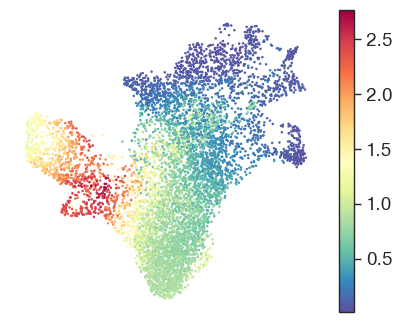

In [37]:
plt.figure(figsize=[5, 4])
plt.scatter(rna_ad.obsm[basis][:, 0], 
            rna_ad.obsm[basis][:, 1], s=1, 
            c=rna_ad[:, 'GATA2'].layers['MAGIC_imputed_data'])
ax = plt.gca()
ax.set_axis_off()
plt.colorbar()
plt.savefig(plot_prefix + 'gata2_with_scale.png', dpi=150)

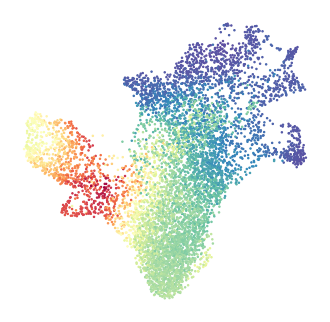

In [38]:
plt.figure(figsize=[4, 4])
plt.scatter(rna_ad.obsm[basis][:, 0], 
            rna_ad.obsm[basis][:, 1], s=1, 
            c=rna_ad[:, 'GATA2'].layers['MAGIC_imputed_data'])
ax = plt.gca()
ax.set_axis_off()
plt.savefig(plot_prefix + 'gata2_no_scale.png', dpi=150)

## Group level

In [39]:
from scipy.stats import rankdata

In [40]:
cluster_colors['MEP G1'] = '#fc8d62'
cluster_colors['MEP G2'] = '#8da0cb'
cluster_colors['MEP G3'] = '#e78ac3'
cluster_colors['MEP'] = ct_colors['MEP']

In [41]:
barcode_groups = pd.Series([], dtype=object)
group_cells = pd.Series([], dtype=object)
for cluster in ['4']:
        
    # Cluster level
    index = 'MEP'
    barcode_groups[index] = pd.Series([], dtype=object)
    for rep in atac_ad.obs['Sample'].values.categories:
        barcode_groups[index][rep] = atac_ad.obs['FragSample'][(rna_ad.obs['leiden'] == cluster) & \
                                                           (atac_ad.obs['Sample'] == rep)].values    

    # Split to 3 groups 
    n_groups = 3
    subset = rna_ad.obs_names[rna_ad.obs['leiden'] == cluster]
    vals = pd.Series(-rankdata(dm_res['EigenVectors'][2][subset]), 
                    index=subset)
    groups = np.digitize(vals, (np.linspace(vals.min(), vals.max(), n_groups + 1)))
    
    for k in range(n_groups):
        index = f'MEP G{k + 1}'
        barcode_groups[index] = pd.Series([], dtype=object)
        group_cells[index] = vals.index[groups == k + 1]
        for rep in atac_ad.obs['Sample'].values.categories:
            rep_cells = vals.index[(groups == k + 1) & vals.index.str.contains(rep)]
            barcode_groups[index][rep] = atac_ad.obs['FragSample'][rep_cells].values


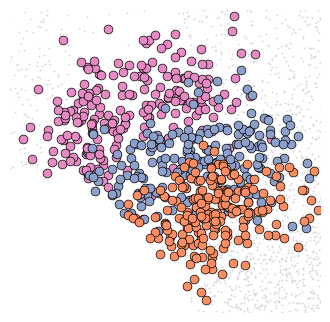

In [42]:
plt.figure()
plt.scatter(rna_ad.obsm[basis][:, 0], 
            rna_ad.obsm[basis][:, 1], s=0.25, color='lightgrey')
for c in group_cells.index[:3][::-1]:
    cells = group_cells[c]
    plt.scatter(rna_ad[cells].obsm[basis][:, 0], 
            rna_ad[cells].obsm[basis][:, 1], s=40, 
                color=cluster_colors[c], edgecolor='black', linewidth=0.5)
ax = plt.gca()
ax.set_xlim([-5, 0])
ax.set_ylim([-7, -1])
ax.set_axis_off()
plt.savefig(plot_prefix + 'mep_groups.png', dpi=150)

In [43]:
cell_subset = np.ravel([v.values for v in group_cells.values])

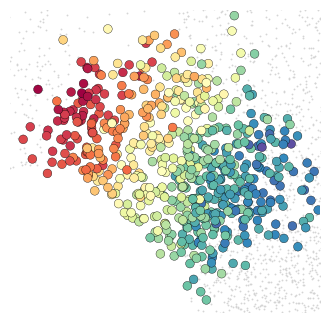

In [44]:
plt.figure()
plt.scatter(rna_ad.obsm[basis][:, 0], 
            rna_ad.obsm[basis][:, 1], s=0.25, color='lightgrey')

plt.scatter(rna_ad[cell_subset].obsm[basis][:, 0], 
            rna_ad[cell_subset].obsm[basis][:, 1], s=40, 
            c=rna_ad[cell_subset][:, 'GATA2'].layers['MAGIC_imputed_data'],
           edgecolor='black', linewidth=0.25)
ax = plt.gca()
ax.set_xlim([-5, 0])
ax.set_ylim([-7, -1])
ax.set_axis_off()
plt.savefig(plot_prefix + 'gata2_subset_no_scale.png', dpi=150)

In [45]:
m = 'Single-cell'
barcode_groups[m] = pd.Series([], dtype=object)
barcode_groups[m]['cd34_multiome_rep1'] = ['GGACCTCAGCAAGGAC-1', 'TCACCTCAGCTTTGGG-1']
barcode_groups[m]['cd34_multiome_rep2'] = barcode_groups[m]['cd34_multiome_rep1']

In [46]:
cluster_colors['Single-cell'] = 'grey'

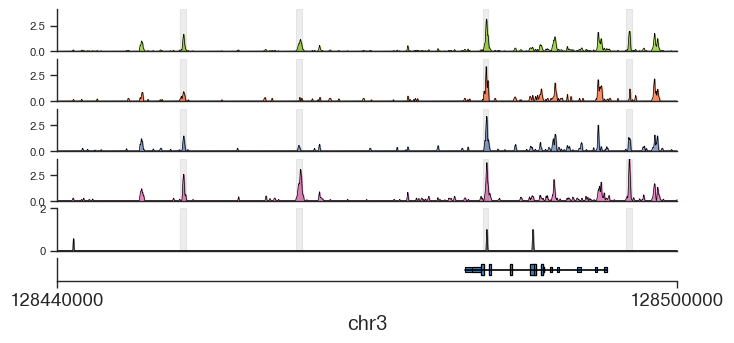

In [48]:
plot_coverage(barcode_groups, region, fragment_files, 
              None, genes=genes, highlight_peaks=highlight_peaks,
              common_scale=True, smooth=75, 
              coverage_colors=cluster_colors, 
              fig_width=8,  plot_cov_size = 0.65, plot_bed_size=0.35,
              frag_type='NFR', normalize=True, y_font=8)
plt.savefig(plot_prefix + 'gata_locus.png', dpi=150)

In [49]:
rna_ad.obs['celltype'].value_counts()

HSC      2042
HMP      1988
Ery       655
DCPre     552
Mono      513
MEP       384
CLP       369
pDC       252
cDC       126
Name: celltype, dtype: int64

In [50]:
ct_barcode_groups = pd.Series([], dtype=object)
for index in ['HSC', 'HMP', 'MEP', 'Ery', 'Mono', 'DCPre', 'cDC', 'pDC', 'CLP']:
        
    # Cluster level
    ct_barcode_groups[index] = pd.Series([], dtype=object)
    for rep in atac_ad.obs['Sample'].values.categories:
        ct_barcode_groups[index][rep] = atac_ad.obs['FragSample'][(rna_ad.obs['celltype'] == index)].values    



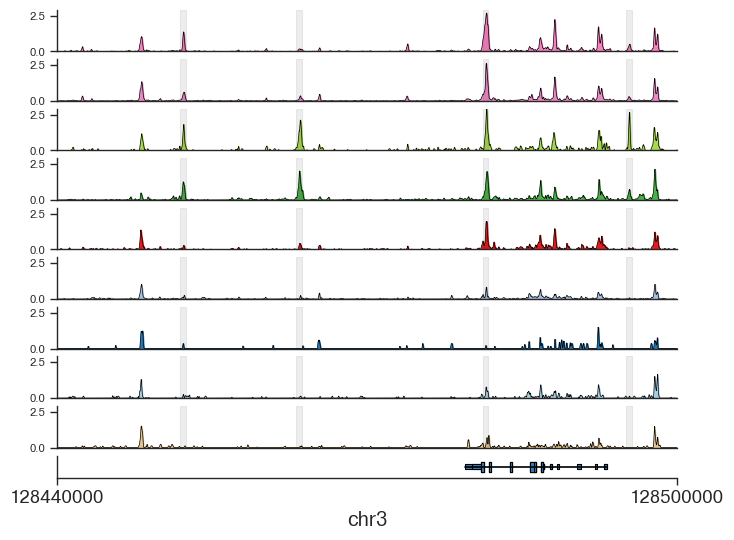

In [51]:
plot_coverage(ct_barcode_groups, region, fragment_files, 
              None, genes=genes, highlight_peaks=highlight_peaks,
              common_scale=True, smooth=75, 
              coverage_colors=ct_colors, 
              fig_width=8,  plot_cov_size = 0.65, plot_bed_size=0.35,
              frag_type='NFR', normalize=True, y_font=8)
plt.savefig(plot_prefix + 'gata_locus_all_celltypes.png', dpi=150)

In [52]:
sc_barcode_groups = pd.Series([], dtype=object)
sc_barcode_groups['MEP'] = ct_barcode_groups['MEP']

for i in np.random.choice(ct_barcode_groups['MEP']['cd34_multiome_rep1'], 20, False):
    sc_barcode_groups[i] = pd.Series([], dtype=object)
    sc_barcode_groups[i]['cd34_multiome_rep1'] = [i]
    sc_barcode_groups[i]['cd34_multiome_rep2'] = [i]


In [53]:
# Remove single-cell with no coverage
coverages = dict()
for k in sc_barcode_groups.index:
    coverages[k] = compute_coverage(fragment_files, region, sc_barcode_groups[k],
                                    '/tmp/test', smooth=75, normalize=False, frag_type='NFR')
coverages = pd.Series(coverages)[pd.Series(coverages).apply(sum) > 0].to_dict()

In [54]:
sc_barcode_groups = sc_barcode_groups[coverages.keys()]

In [55]:
sc_colors = pd.Series(sns.color_palette('Set3', len(sc_barcode_groups.index)).as_hex(), 
        index=sc_barcode_groups.index)
sc_colors['MEP'] = ct_colors['MEP']

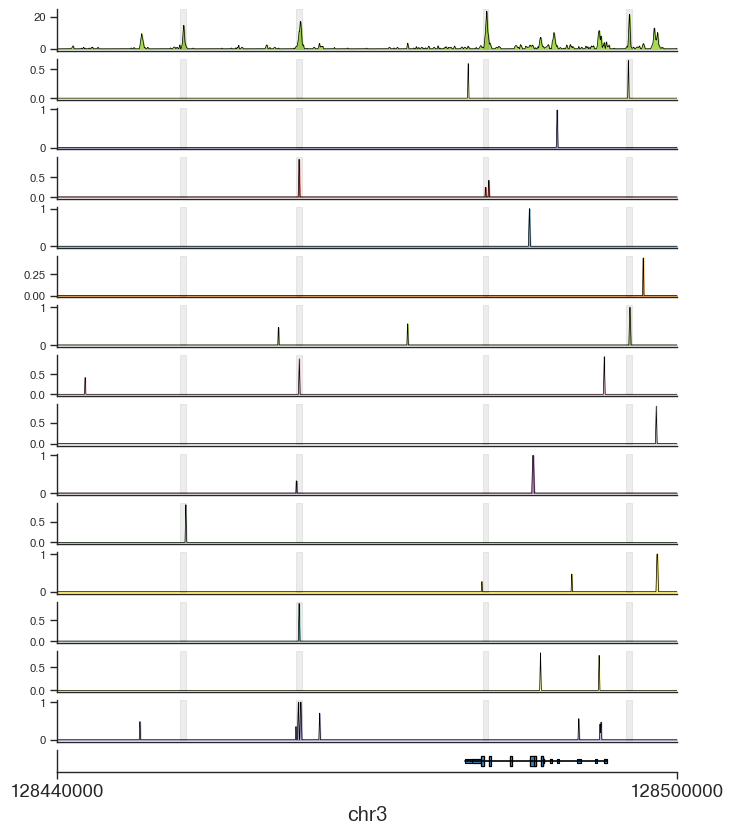

In [56]:
plot_coverage(sc_barcode_groups, region, fragment_files, 
              None, genes=genes, highlight_peaks=highlight_peaks,
              common_scale=False, smooth=75, 
              coverage_colors=sc_colors, 
              fig_width=8,  plot_cov_size = 0.65, plot_bed_size=0.35,
              frag_type='NFR', normalize=False, y_font=8)
plt.savefig(plot_prefix + 'gata_locus_singlecell.png', dpi=150)

## Expression

In [57]:
gene = 'GATA2'
df = pd.DataFrame(np.ravel(rna_ad[:, gene].layers['MAGIC_imputed_data']))
df.index = rna_ad.obs_names
df.columns = [gene]
df['Celltype'] = rna_ad.obs['celltype'].astype(str)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

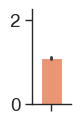

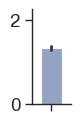

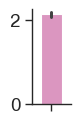

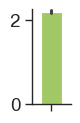

In [58]:
for plot_index, i in enumerate(group_cells.index):
    plt.figure(figsize=[0.5, 1.25])
    sub_df = df.loc[df.index.isin(group_cells[i]), :]
    sub_df['Celltype'] = i
    sns.barplot(x='Celltype', y=gene, 
            data=sub_df, palette=cluster_colors.to_dict())
    plt.ylim([0, 2.25])
    plt.xlim([-0.75, 0.75])
    sns.despine()
    plt.xlabel("")
    plt.ylabel("")
    ax = plt.gca()
    ax.set_xticklabels([])
    plt.savefig(plot_prefix + f'gata_exprs_{plot_index}.png', dpi=150)


plt.figure(figsize=[0.5, 1.25])
sub_df = df.loc[df['Celltype'] == 'MEP', :]
sns.barplot(x='Celltype', y=gene, 
        data=sub_df, palette=cluster_colors.to_dict())
plt.ylim([0, 2.25])
plt.xlim([-0.75, 0.75])
sns.despine()
plt.xlabel("")
plt.ylabel("")
ax = plt.gca()
ax.set_xticklabels([])
plt.savefig(plot_prefix + f'gata_exprs_{plot_index + 1}.png', dpi=150)


# Plots - KLF1

In [61]:
# Pax5 locus 
region = 'chr19:12,859,278-12,912,309'.replace(',', '')
pr_region = pr.from_dict({'Chromosome': [region.split(':')[0]],
                              'Start': [int(region.split(':')[1].split('-')[0])],
                              'End': [int(region.split('-')[1])]})

genes = gtf.intersect(pr_region)
genes = genes[genes.gene_name == 'KLF1']

In [62]:
highlight_peaks = pyranges_from_strings(pd.Series(pyranges_to_strings(peak_groups['Peaks'].intersect(
    pr_region))[[3, ]]))

In [63]:
test_clusters = ['2']
cluster_colors = pd.Series(['#e41a1c',], 
                           index=['Ery'])

In [64]:
ct_colors = pd.Series(rna_ad.uns['celltype_colors'], 
                     index=rna_ad.obs['celltype'].values.categories)

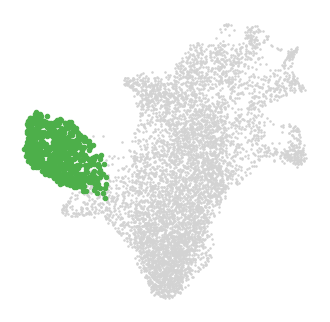

In [65]:
plt.figure()
basis = 'X_umap'
plt.scatter(rna_ad.obsm[basis][:, 0], 
            rna_ad.obsm[basis][:, 1], s=1, color='lightgrey')
for c in test_clusters:
    cells = rna_ad.obs_names[rna_ad.obs['leiden'] == c]
    plt.scatter(rna_ad[cells].obsm[basis][:, 0], 
            rna_ad[cells].obsm[basis][:, 1], s=10, 
                color=ct_colors['Ery'])
ax = plt.gca()
ax.set_axis_off()


# plt.savefig(plot_prefix + 'highlight_mep.png', dpi=150)

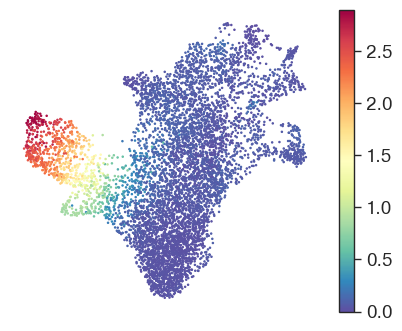

In [66]:
plt.figure(figsize=[5, 4])
plt.scatter(rna_ad.obsm[basis][:, 0], 
            rna_ad.obsm[basis][:, 1], s=1, 
            c=rna_ad[:, 'KLF1'].layers['MAGIC_imputed_data'])
ax = plt.gca()
ax.set_axis_off()
plt.colorbar()
# plt.savefig(plot_prefix + 'gata2_with_scale.png', dpi=150)

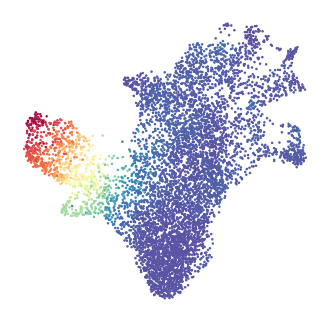

In [67]:
plt.figure(figsize=[4, 4])
plt.scatter(rna_ad.obsm[basis][:, 0], 
            rna_ad.obsm[basis][:, 1], s=1, 
            c=rna_ad[:, 'KLF1'].layers['MAGIC_imputed_data'])
ax = plt.gca()
ax.set_axis_off()
# plt.savefig(plot_prefix + 'gata2_no_scale.png', dpi=150)

## Group level

In [68]:
from scipy.stats import rankdata

In [69]:
cluster_colors['Ery G1'] = '#fc8d62'
cluster_colors['Ery G2'] = '#8da0cb'
cluster_colors['Ery G3'] = '#e78ac3'
cluster_colors['Ery'] = ct_colors['Ery']

In [70]:
n_groups = 5

In [71]:
barcode_groups = pd.Series([], dtype=object)
group_cells = pd.Series([], dtype=object)
for cluster in ['2']:
        
    # Cluster level
    index = 'Ery'
    barcode_groups[index] = pd.Series([], dtype=object)
    for rep in atac_ad.obs['Sample'].values.categories:
        barcode_groups[index][rep] = atac_ad.obs['FragSample'][(rna_ad.obs['leiden'] == cluster) & \
                                                           (atac_ad.obs['Sample'] == rep)].values    

    # Split to 3 groups 
    subset = rna_ad.obs_names[rna_ad.obs['leiden'] == cluster]
    vals = pd.Series(-rankdata(dm_res['EigenVectors'][2][subset]), 
                    index=subset)
    groups = np.digitize(vals, (np.linspace(vals.min(), vals.max(), n_groups + 1)))
    
    for k in range(n_groups):
        index = f'Ery G{k + 1}'
        barcode_groups[index] = pd.Series([], dtype=object)
        group_cells[index] = vals.index[groups == k + 1]
        for rep in atac_ad.obs['Sample'].values.categories:
            rep_cells = vals.index[(groups == k + 1) & vals.index.str.contains(rep)]
            barcode_groups[index][rep] = atac_ad.obs['FragSample'][rep_cells].values


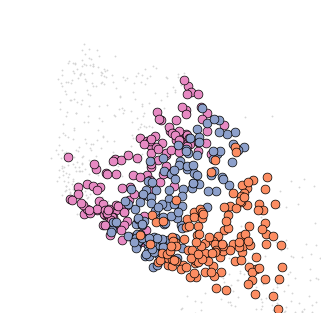

In [72]:
plt.figure()
plt.scatter(rna_ad.obsm[basis][:, 0], 
            rna_ad.obsm[basis][:, 1], s=0.25, color='lightgrey')
for c in group_cells.index[:3][::-1]:
    cells = group_cells[c]
    plt.scatter(rna_ad[cells].obsm[basis][:, 0], 
            rna_ad[cells].obsm[basis][:, 1], s=40, 
                color=cluster_colors[c], edgecolor='black', linewidth=0.5)
ax = plt.gca()
ax.set_xlim([-9, -3])
ax.set_ylim([-3.25, 2])
ax.set_axis_off()
# plt.savefig(plot_prefix + 'mep_groups.png', dpi=150)

In [73]:
m = 'Single-cell'
barcode_groups[m] = pd.Series([], dtype=object)
barcode_groups[m]['cd34_multiome_rep1'] = ['GGACCTCAGCAAGGAC-1', 'TCACCTCAGCTTTGGG-1']
barcode_groups[m]['cd34_multiome_rep2'] = barcode_groups[m]['cd34_multiome_rep1']

In [74]:
cluster_colors['Single-cell'] = 'grey'

In [75]:
# Pax5 locus 
region = 'chr11:36,032,746-36,204,316'.replace(',', '')
pr_region = pr.from_dict({'Chromosome': [region.split(':')[0]],
                              'Start': [int(region.split(':')[1].split('-')[0])],
                              'End': [int(region.split('-')[1])]})

# genes = gtf.intersect(pr_region)
# genes = genes[genes.gene_name == 'KCNK5']

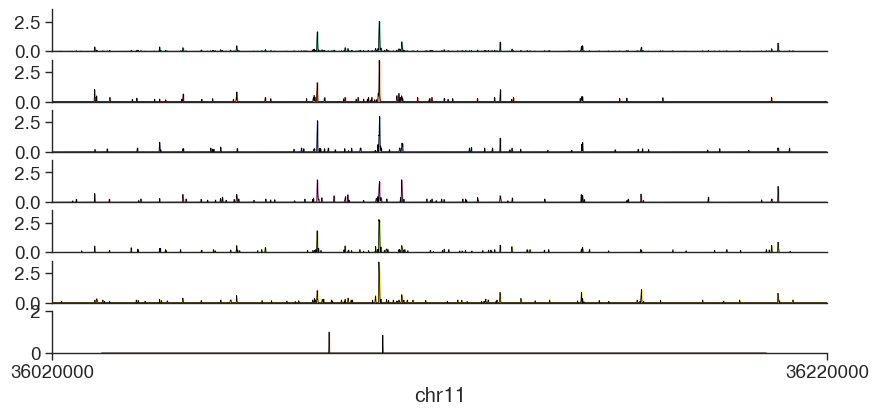

In [76]:
plot_coverage(barcode_groups, region, fragment_files, 
              None, genes=None, highlight_peaks=None,
              common_scale=True, smooth=75, 
              coverage_colors=None, 
              fig_width=10,  plot_cov_size = 0.65, plot_bed_size=0.35,
              frag_type='NFR', normalize=True)
# plt.savefig(plot_prefix + 'gata_locus.png', dpi=150)

# Metacell concept figure

## Clusters 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'FragSample' as categorical


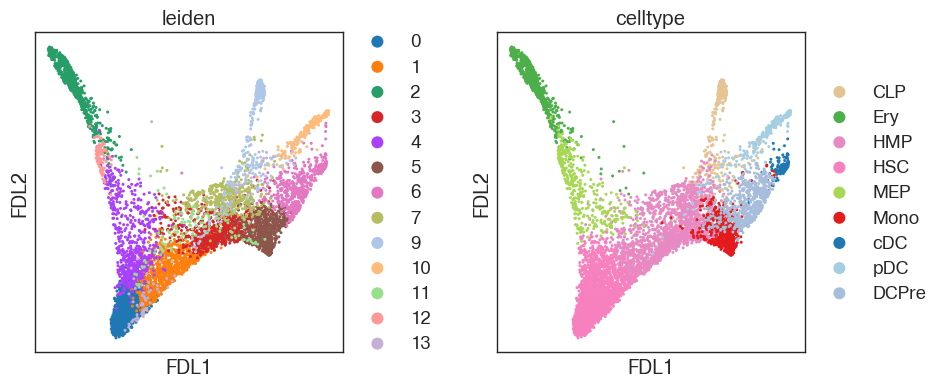

In [77]:
sc.pl.scatter(rna_ad[rna_ad.obs['leiden'] != '8', :], basis='FDL', color=['leiden', 'celltype'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'FragSample' as categorical


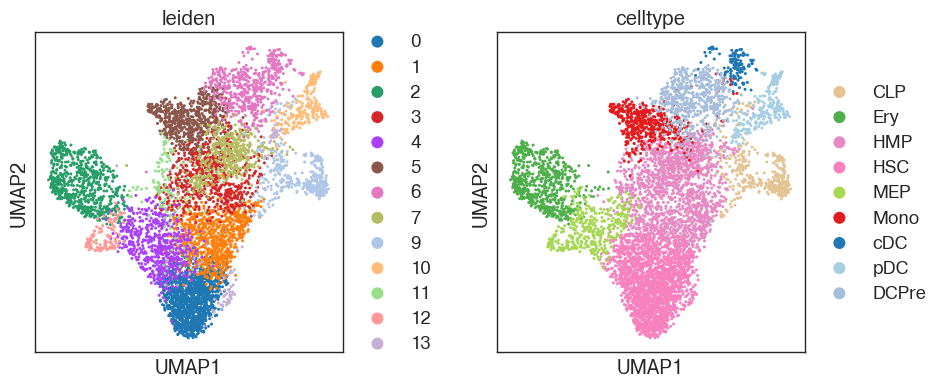

In [78]:
sc.pl.scatter(rna_ad[rna_ad.obs['leiden'] != '8', :], basis='umap', color=['leiden', 'celltype'])

In [79]:
temp = rna_ad.obs['leiden'].astype(str)
temp[rna_ad.obs['phenograph'] == '4'] = '14'

rna_ad.obs['temp'] = temp.values

... storing 'FragSample' as categorical
... storing 'temp' as categorical


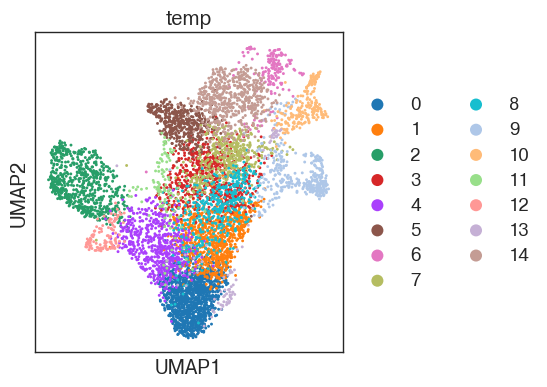

In [80]:
sc.pl.scatter(rna_ad, basis='umap', color=['temp'])

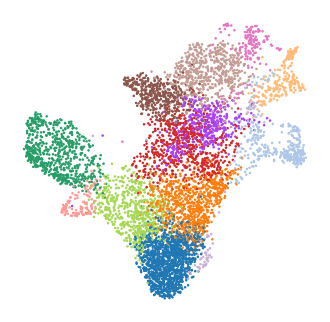

In [81]:
metacell_colors = pd.Series(rna_ad.uns['temp_colors'], 
                           index=rna_ad.obs['temp'].values.categories)
metacell_colors['7'] = metacell_colors['4']
metacell_colors['4'] = ct_colors['MEP']
basis = 'X_umap'
cells = rna_ad.obs_names[~rna_ad.obs['temp'].isin(['8', '11'])]
plt.scatter(rna_ad[cells].obsm[basis][:, 0], 
            rna_ad[cells].obsm[basis][:, 1], s=1, 
            color=metacell_colors[rna_ad[cells].obs['temp']])
ax = plt.gca()
ax.set_axis_off()
plt.savefig(plot_prefix + 'clusters.png', dpi=150)

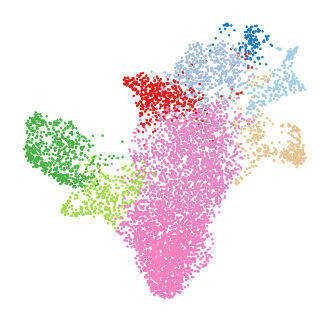

In [82]:
ct_colors = pd.Series(sns.color_palette(rna_ad.uns['celltype_colors']).as_hex(), 
         index=rna_ad.obs['celltype'].values.categories)

basis = 'X_umap'
plt.scatter(rna_ad.obsm[basis][:, 0], 
            rna_ad.obsm[basis][:, 1], s=1, 
            color=ct_colors[rna_ad.obs['celltype']])
ax = plt.gca()
ax.set_axis_off()
plt.savefig(plot_prefix + 'celltypes.png', dpi=150)

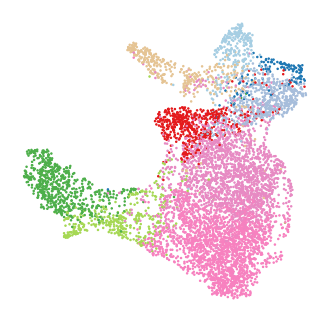

In [83]:
ct_colors = pd.Series(sns.color_palette(rna_ad.uns['celltype_colors']).as_hex(), 
         index=rna_ad.obs['celltype'].values.categories)

basis = 'X_umap'
plt.scatter(-atac_ad.obsm[basis][:, 0], 
            atac_ad.obsm[basis][:, 1], s=1, 
            color=ct_colors[rna_ad.obs['celltype']])
ax = plt.gca()
ax.set_axis_off()
plt.savefig(plot_prefix + 'atac_celltypes.png', dpi=150)

## Contour plot

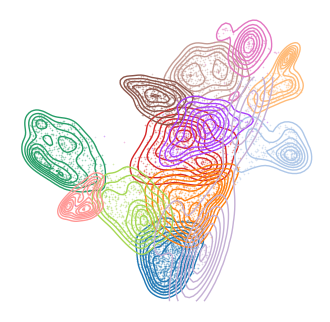

In [84]:
from scipy.stats import gaussian_kde

delta = 1

fig, ax = plt.subplots()

basis = 'X_umap'
for m in rna_ad.obs['temp'].unique():
    if m == '8' or m == '11':# or m =='7':
        continue
    
    # Cells 
    cells = rna_ad.obs_names[rna_ad.obs['temp'] == m]
    if len(cells) < 5:
        continue
    x = rna_ad[cells].obsm[basis][:, 0]
    y = rna_ad[cells].obsm[basis][:, 1]

    xmin, xmax = rna_ad[cells].obsm[basis][:, 0].min() - delta, rna_ad[cells].obsm[basis][:, 0].max() + delta
    ymin, ymax = rna_ad[cells].obsm[basis][:, 1].min() - delta, rna_ad[cells].obsm[basis][:, 1].max() + delta

    xx, yy = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    ax.contour(xx, yy, f, colors=metacell_colors[m], linewidths=1)
    
    ax.scatter(x, y, s=0.05, color=metacell_colors[m], zorder=2, alpha=0.75)

ax.set_axis_off()

# plt.scatter(rna_ad[rna_metacells].obsm[basis][:, 0], 
#             rna_ad[rna_metacells].obsm[basis][:, 1], s=10, 
#            color=metacell_colors[rna_metacells], edgecolor='black', alpha=0.85, zorder=2)

# plt.xlim(xlim)
# plt.ylim(ylim)


plt.savefig(plot_prefix + 'contours.png', dpi=150)

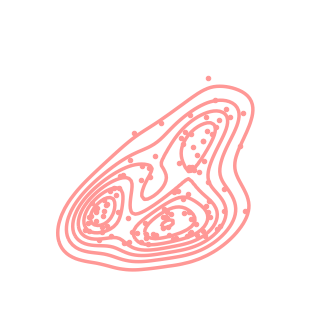

In [85]:
from scipy.stats import gaussian_kde

delta = 1

fig, ax = plt.subplots()

basis = 'X_umap'
m = '12'    

# Cells 
cells = rna_ad.obs_names[rna_ad.obs['temp'] == m]
x = rna_ad[cells].obsm[basis][:, 0]
y = rna_ad[cells].obsm[basis][:, 1]

xmin, xmax = rna_ad[cells].obsm[basis][:, 0].min() - delta, rna_ad[cells].obsm[basis][:, 0].max() + delta
ymin, ymax = rna_ad[cells].obsm[basis][:, 1].min() - delta, rna_ad[cells].obsm[basis][:, 1].max() + delta

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)
ax.contour(xx, yy, f, colors=metacell_colors[m], linewidths=2.5)
    
ax.scatter(x, y, s=10, color=metacell_colors[m], zorder=2)

ax.set_axis_off()
plt.savefig(plot_prefix + 'contours_mep.png', dpi=150)

## Gene expression programs

In [86]:
rna_res = pd.read_csv('/home/ec2-user/projects/metacells/comparisons/cd34_multiome_rna_no_bcells_results/labels.csv', 
           index_col=0)
common = rna_res.index.intersection(rna_ad.obs_names)

rna_res = rna_res.loc[common, :]
# rna_ad = rna_ad[common, :]

In [87]:
cells = common.intersection(rna_ad.obs_names[rna_ad.obs['leiden'] == '9'])

In [88]:
s1 = 'cd34_multiome_rep2#GTGCATTAGCAGCTCA-1'
# s2 = 'cd34_multiome_rep2#TTGTCCCAGTAACTCA-1'
s2 = 'cd34_multiome_rep2#TTGCAGCCATAGCGAG-1'


cells1 = rna_res.index[rna_res['waypoint_labels'] == s1]
cells2 = rna_res.index[rna_res['waypoint_labels'] == s2]

In [89]:
imp_df = pd.DataFrame(rna_ad.layers['MAGIC_imputed_data'], 
                     index=rna_ad.obs_names, columns=rna_ad.var_names)


In [90]:
sc.tl.rank_genes_groups(rna_ad, groupby='leiden')

In [91]:
num_genes = 7
g1 = rna_ad.var_names[sc.get.rank_genes_groups_df(rna_ad, '12')['names'].astype(int)][:num_genes]
g2 = rna_ad.var_names[sc.get.rank_genes_groups_df(rna_ad, '9')['names'].astype(int)][:num_genes]

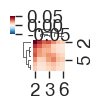

In [92]:
r1 = sns.clustermap(np.cov(imp_df.loc[cells1, g1].T), vmin=-0.05, vmax=0.05, 
              cmap=matplotlib.cm.RdBu_r, figsize=[1, 1])
g1 = g1[r1.dendrogram_row.reordered_ind]

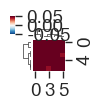

In [93]:
r2 = sns.clustermap(np.cov(imp_df.loc[cells2, g2].T), vmin=-0.05, vmax=0.05, 
              cmap=matplotlib.cm.RdBu_r, figsize=[1, 1])
g2 = g2[r2.dendrogram_row.reordered_ind]

In [94]:
colors = np.repeat(['#66c2a5', '#8da0cb'], num_genes)
colors

array(['#66c2a5', '#66c2a5', '#66c2a5', '#66c2a5', '#66c2a5', '#66c2a5',
       '#66c2a5', '#8da0cb', '#8da0cb', '#8da0cb', '#8da0cb', '#8da0cb',
       '#8da0cb', '#8da0cb'], dtype='<U7')

In [95]:
sns.clustermap?

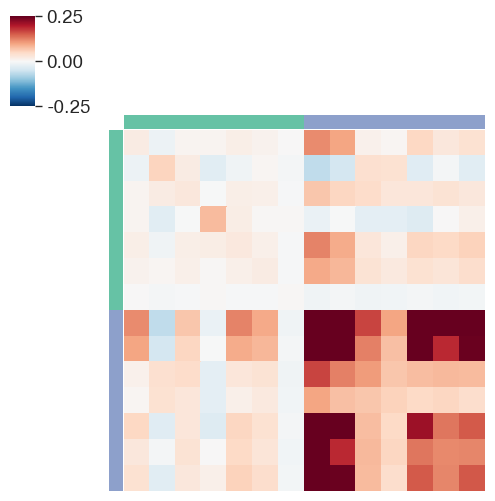

In [96]:
sns.clustermap(np.cov(imp_df.loc[cells2, g1.append(g2)].T), vmin=-0.25, vmax=0.25, 
              cmap=matplotlib.cm.RdBu_r, row_cluster=False, col_cluster=False, figsize=[5, 5], 
              xticklabels=False, yticklabels=False, 
               row_colors=colors, col_colors=colors)
plt.savefig(plot_prefix + 'heatmap1.png', dpi=150)

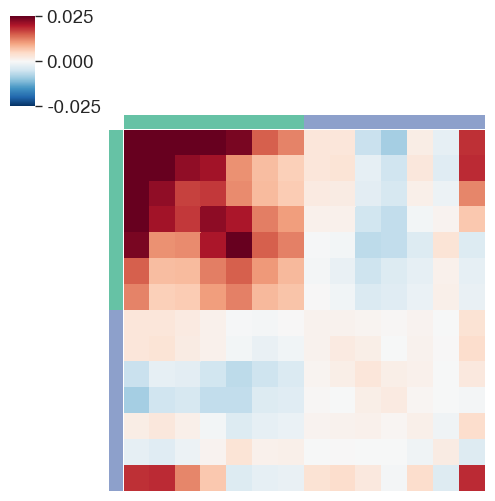

In [97]:
sns.clustermap(np.cov(imp_df.loc[cells1, g1.append(g2)].T), vmin=-0.025, vmax=0.025, 
              cmap=matplotlib.cm.RdBu_r, row_cluster=False, col_cluster=False, figsize=[5, 5], 
              xticklabels=False, yticklabels=False,
               row_colors=colors, col_colors=colors)
plt.savefig(plot_prefix + 'heatmap2.png', dpi=150)

# Metacell contour plot

In [98]:
waypoint_res = rna_res['waypoint_labels']

In [99]:
atac_metacells = waypoint_res.unique()
metacell_colors = pd.Series(sns.color_palette(n_colors=len(atac_metacells)).as_hex(),
                            index=np.random.choice(atac_metacells, len(atac_metacells), False))

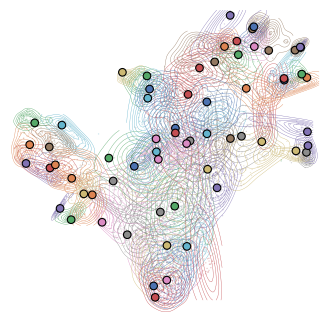

In [100]:
from scipy.stats import gaussian_kde

delta = 0.25

fig, ax = plt.subplots()

basis = 'X_umap'
for m in atac_metacells:
    # Cells 
    cells = waypoint_res.index[waypoint_res == m]
    if len(cells) < 5:
        continue
    x = rna_ad[cells].obsm[basis][:, 0]
    y = rna_ad[cells].obsm[basis][:, 1]

    xmin, xmax = rna_ad[cells].obsm[basis][:, 0].min() - delta, rna_ad[cells].obsm[basis][:, 0].max() + delta
    ymin, ymax = rna_ad[cells].obsm[basis][:, 1].min() - delta, rna_ad[cells].obsm[basis][:, 1].max() + delta

    xx, yy = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    ax.contour(xx, yy, f, colors=metacell_colors[m], linewidths=0.25)

ax.scatter(rna_ad[atac_metacells].obsm[basis][:, 0],
           rna_ad[atac_metacells].obsm[basis][:, 1],
           s=30, color=metacell_colors[atac_metacells], zorder=3, 
          edgecolor='black')

plot_set = rna_ad.obs_names.intersection(waypoint_res.index)
ax.scatter(rna_ad[plot_set].obsm[basis][:, 0],
           rna_ad[plot_set].obsm[basis][:, 1],
           s=0.5, color=metacell_colors[waypoint_res[plot_set]], zorder=2, 
          edgecolor=metacell_colors[waypoint_res[plot_set]], linewidths=0.25, alpha=0.25)

ax.set_axis_off()

# plt.scatter(rna_ad[rna_metacells].obsm[basis][:, 0], 
#             rna_ad[rna_metacells].obsm[basis][:, 1], s=10, 
#            color=metacell_colors[rna_metacells], edgecolor='black', alpha=0.85, zorder=2)

# plt.xlim(xlim)
# plt.ylim(ylim)

plt.savefig(plot_prefix + 'metacell_contour.png', dpi=150)